In [1]:
# Install PyTorch 2 and download training data
init_script = f"""
if [[ -f done ]]; then exit 0; fi

curl -fsSL -o images.tar http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
curl -fsSL -o annotations.tar http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

tar xf images.tar
tar xf annotations.tar

touch done
"""

with open('init.sh', mode='w', encoding='utf-8') as f:
  f.write(init_script)

!bash init.sh

In [2]:
import torch

BATCH_SIZE = 256
EPOCHS = 100
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Running on {DEVICE}')

Running on cpu


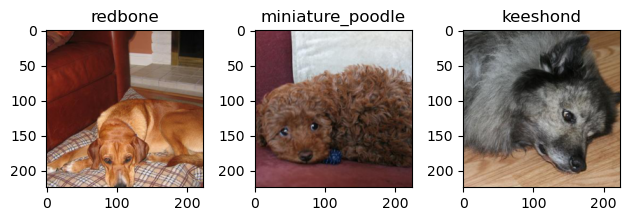

In [3]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, RandomCrop, ToTensor

dogs_dataset = ImageFolder('./Images', transform=Compose([
                                          ToTensor(),
                                          Resize(256, antialias=True),
                                          RandomCrop(224)
                                        ]))

idx_to_class = {v: k.split('-')[1] for k, v in dogs_dataset.class_to_idx.items()}

for i in range(3):
  idx = torch.randint(len(dogs_dataset), (1,))
  data = dogs_dataset[idx]

  ax = plt.subplot(1, 3, i + 1)

  plt.imshow(data[0].numpy().transpose(1, 2, 0))
  ax.set_title(f'{idx_to_class[data[1]]}')

plt.tight_layout()
plt.show()

In [9]:
from multiprocessing import cpu_count
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dogs_dataset))
test_size = len(dogs_dataset) - train_size
train_dataset, test_dataset = random_split(dogs_dataset,
                                           [train_size, test_size])

trainloader = DataLoader(train_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=cpu_count())

testloader = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=cpu_count())

dataloaders_dict = {
  'train': trainloader,
  'val': testloader
}

In [10]:
import time
from torch import nn, optim

def train_model(model: nn.Module,
                dataloaders: dict,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                num_epochs: int):
  since = time.time()
  val_loss_history = []
  val_acc_history = []

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

      if phase == 'val':
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)
        plt.plot(range(len(val_loss_history)), val_loss_history)
        if epoch % 5 == 0:
          torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'loss_history': val_loss_history,
            'acc_history': val_acc_history
          }, f'snapshot-{epoch}')
          print(f'snapshot-{epoch} saved...')

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
  return model, val_acc_history

In [11]:
from torchvision.models import resnet

model = resnet.resnet50(weights=resnet.ResNet50_Weights.DEFAULT)

for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(2048, 120)
model = model.to(DEVICE)

params_to_update = []
for name, param in model.named_parameters():
  if param.requires_grad:
    params_to_update.append(param)

optimizer = optim.Adam(params_to_update)
criterion = nn.CrossEntropyLoss()

model, hist = train_model(model,
                          dataloaders_dict,
                          criterion,
                          optimizer,
                          num_epochs=EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/99
----------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [17]:
!curl -fsSL -o test.jpg https://i.ibb.co/Hn4FTJH/test.jpg

In [1]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from matplotlib import pyplot as plt

pred_model = torch.load('epoch-100', map_location=torch.device('cpu')).eval()

img = read_image('test.jpg') / 255
img = resize(img, [224, 224], antialias=True)
pred = pred_model(img.float().unsqueeze(0))
idx = torch.max(pred, 1).indices[0].item()
plt.imshow(img.numpy().transpose(1, 2, 0))

NameError: name 'torch' is not defined

In [4]:
idx_to_class

{0: 'Chihuahua',
 1: 'Japanese_spaniel',
 2: 'Maltese_dog',
 3: 'Pekinese',
 4: 'Shih',
 5: 'Blenheim_spaniel',
 6: 'papillon',
 7: 'toy_terrier',
 8: 'Rhodesian_ridgeback',
 9: 'Afghan_hound',
 10: 'basset',
 11: 'beagle',
 12: 'bloodhound',
 13: 'bluetick',
 14: 'black',
 15: 'Walker_hound',
 16: 'English_foxhound',
 17: 'redbone',
 18: 'borzoi',
 19: 'Irish_wolfhound',
 20: 'Italian_greyhound',
 21: 'whippet',
 22: 'Ibizan_hound',
 23: 'Norwegian_elkhound',
 24: 'otterhound',
 25: 'Saluki',
 26: 'Scottish_deerhound',
 27: 'Weimaraner',
 28: 'Staffordshire_bullterrier',
 29: 'American_Staffordshire_terrier',
 30: 'Bedlington_terrier',
 31: 'Border_terrier',
 32: 'Kerry_blue_terrier',
 33: 'Irish_terrier',
 34: 'Norfolk_terrier',
 35: 'Norwich_terrier',
 36: 'Yorkshire_terrier',
 37: 'wire',
 38: 'Lakeland_terrier',
 39: 'Sealyham_terrier',
 40: 'Airedale',
 41: 'cairn',
 42: 'Australian_terrier',
 43: 'Dandie_Dinmont',
 44: 'Boston_bull',
 45: 'miniature_schnauzer',
 46: 'giant_schna